# Chapter 10 - Exercises

In [1]:
library(tidyverse)
library(bayesrules)
library(bayesplot)
library(rstan)
library(rstanarm)
library(broom.mixed)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: StanHeaders

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recomp

## Exercise 10.7

Specify values:

In [2]:
beta0 <- -1.8
beta1 <- 2.1
sigma <- 0.8
x <- data.frame( x=c(12,10,4,8,6), y=c(20,17,4,11,9) )

Sample predictions:

In [3]:
sim <- x %>% 
    mutate( mu = beta0+beta1*x ) %>% 
    mutate( ypred = rnorm(n=n(), mean=mu, sd=sigma) ) 

sim

x,y,mu,ypred
<dbl>,<dbl>,<dbl>,<dbl>
12,20,23.4,23.912431
10,17,19.2,20.330261
4,4,6.6,6.260318
8,11,15.0,14.782503
6,9,10.8,10.488687


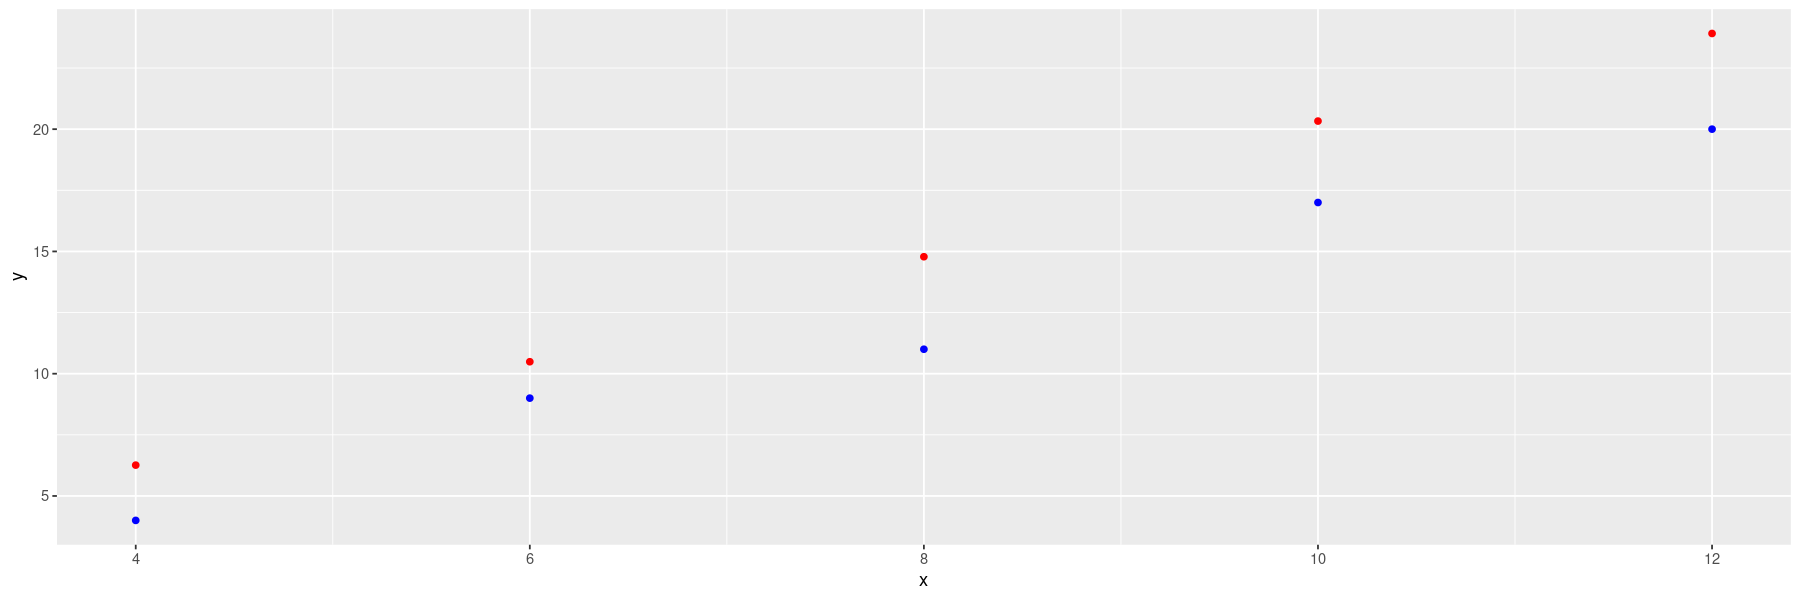

In [4]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot( data=sim ) +
    geom_point( aes(x=x, y=y), color="blue" ) +
    geom_point( aes(x=x, y=ypred), color="red" )

Blue: original data, red: simulated data. The model seems to have a small systematical bias in the intercept, however more data would be needed to confirm this.

## Exercise 10.13

### a)

In [5]:
dim( coffee_ratings )

[1] 1339   27

In [6]:
head( coffee_ratings )

owner,farm_name,mill,in_country_partner,country_of_origin,altitude_low_meters,altitude_high_meters,altitude_mean_meters,number_of_bags,bag_weight,⋯,body,balance,uniformity,clean_cup,sweetness,moisture,category_one_defects,category_two_defects,color,total_cup_points
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
metad plc,metad plc,metad plc,METAD Agricultural Development plc,Ethiopia,1950,2200,2075,300,60 kg,⋯,8.50,8.42,10,10,10,0.12,0,0,Green,90.58
metad plc,metad plc,metad plc,METAD Agricultural Development plc,Ethiopia,1950,2200,2075,300,60 kg,⋯,8.42,8.42,10,10,10,0.12,0,1,Green,89.92
grounds for health admin,"san marcos barrancas ""san cristobal cuch",NA,Specialty Coffee Association,Guatemala,1600,1800,1700,5,1,⋯,8.33,8.42,10,10,10,0.00,0,0,NA,89.75
yidnekachew dabessa,yidnekachew dabessa coffee plantation,wolensu,METAD Agricultural Development plc,Ethiopia,1800,2200,2000,320,60 kg,⋯,8.50,8.25,10,10,10,0.11,0,2,Green,89.00
metad plc,metad plc,metad plc,METAD Agricultural Development plc,Ethiopia,1950,2200,2075,300,60 kg,⋯,8.42,8.33,10,10,10,0.12,0,2,Green,88.83
ji-ae ahn,NA,NA,Specialty Coffee Institute of Asia,Brazil,NA,NA,NA,100,30 kg,⋯,8.25,8.33,10,10,10,0.11,0,1,Bluish-Green,88.83


Some farms appear multiple times, potentially resulting in correlation of the total coffee ratings.

### b)

In [7]:
set.seed(84735)
new_coffee <- coffee_ratings %>% 
  group_by(farm_name) %>% 
  sample_n(1) %>% 
  ungroup()
dim(new_coffee)

[1] 572  27

## Exercise 10.14

Model:


$Y_i \sim N(\mu_i, \sigma)$, $\mu_i = \beta_0 + \beta_1 X_i$

$\beta_0 \sim N(\mu=75, \sigma=8)$

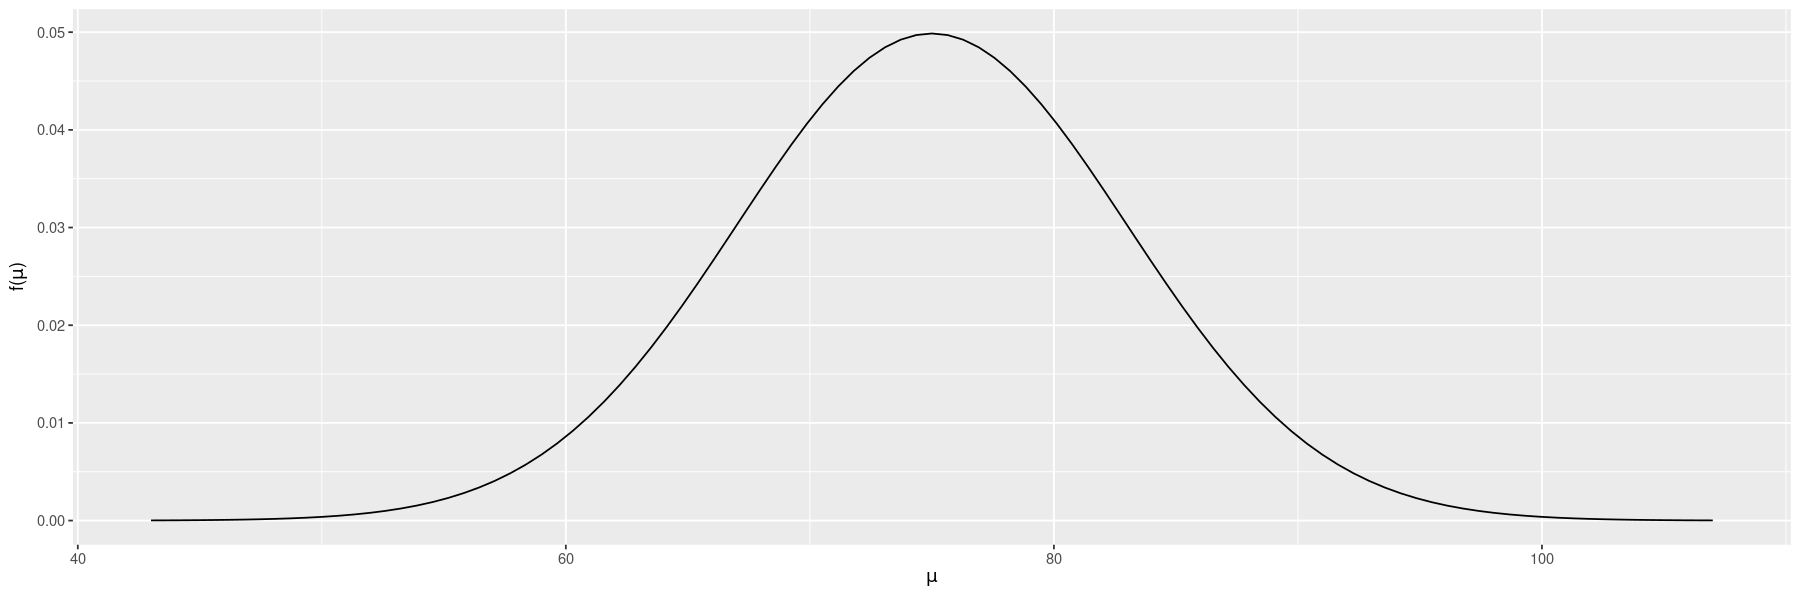

In [8]:
options(repr.plot.width=15, repr.plot.height=5)
plot_normal( mean=75, sd=8 )

### a)

`geom_smooth()` using formula = 'y ~ x'


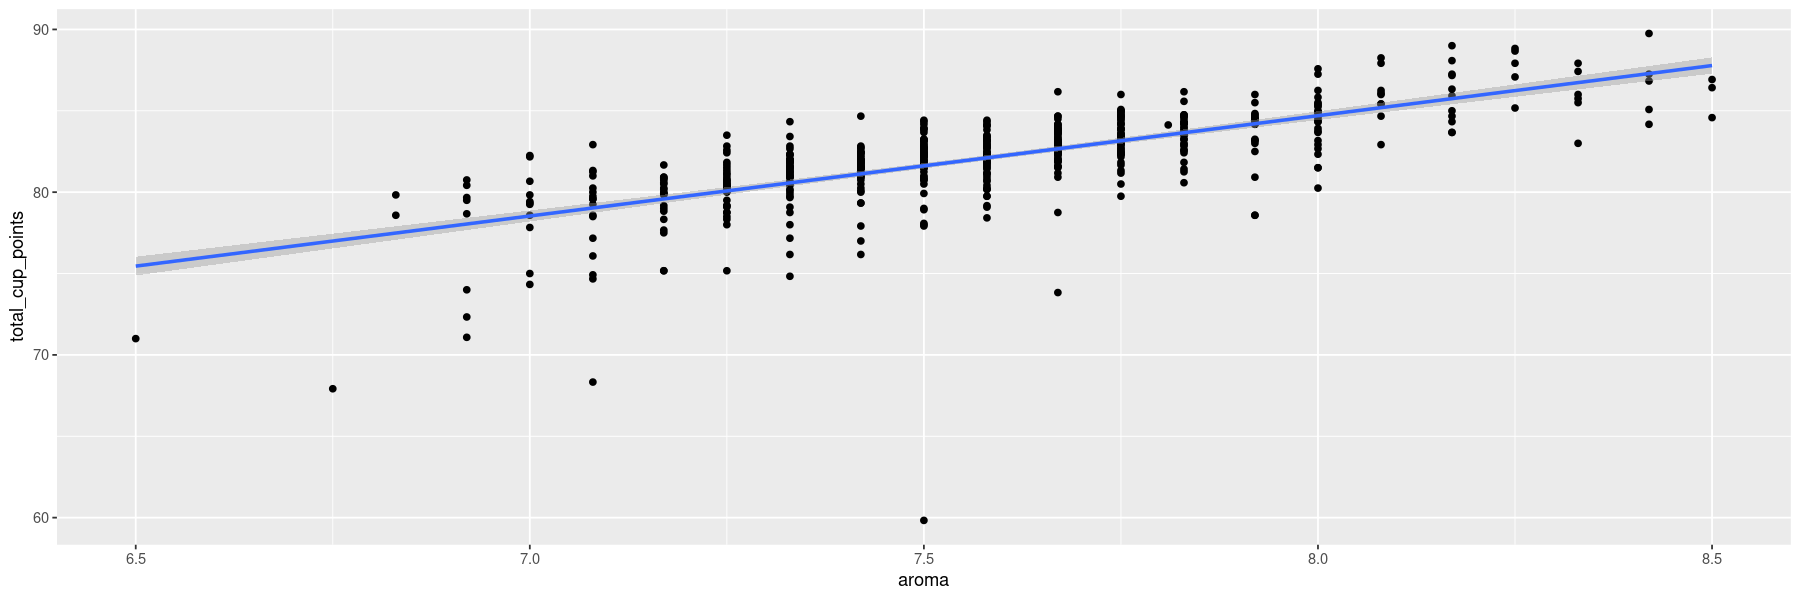

In [9]:
ggplot( new_coffee, aes(x=aroma, y=total_cup_points) ) + geom_point() + geom_smooth( method="lm" )

The relationship looks more or less linear and might be modeled with a linear model - however one could evaluate whether a non-linear model works slightly better here. Of course we expect the cup points to increase with aroma. From first sight the distribution of total_cup_points conditioned on aroma looks a bit skewed.

### b)

I roughly estimate a slope of 10 (going from 7 to 8 on the aroma scale results in a point improvement of around 10).

In [10]:
coffee_model <- stan_glm(
    total_cup_points ~ aroma, data = new_coffee,
    family = gaussian,
    prior_intercept = normal(75, 8),
    prior = normal(10, 100, autoscale=TRUE), 
    prior_aux = exponential(1, autoscale=TRUE),
    chains = 4, iter = 5000*2, seed = 84735
)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.194252 seconds (Warm-up)
Chain 1:                0.235449 seconds (Sampling)
Chain 1: 

adjusted priors:

In [11]:
prior_summary( coffee_model )

Priors for model 'coffee_model' 
------
Intercept (after predictors centered)
 ~ normal(location = 75, scale = 8)

Coefficients
  Specified prior:
    ~ normal(location = 10, scale = 100)
  Adjusted prior:
    ~ normal(location = 10, scale = 877)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.36)
------
See help('prior_summary.stanreg') for more details

### c)

Visual summary:

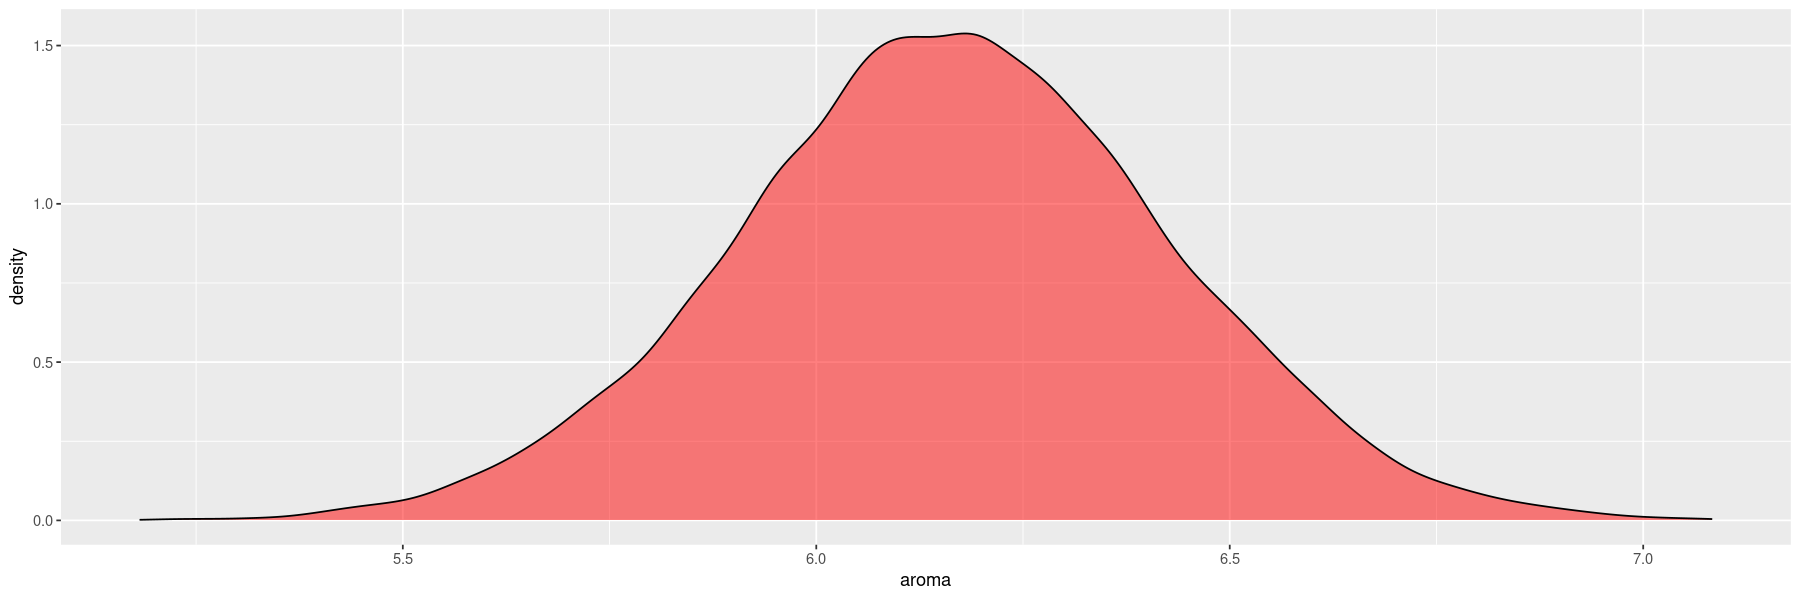

In [12]:
coffee_model_df <- data.frame( coffee_model )
ggplot( coffee_model_df ) + geom_density( aes(x=aroma), fill="red", alpha=0.5 )

The slope is rather around 6.2 than 10.

Numerical summary:

In [13]:
coffee_model_df %>% 
    summarize( mean=mean(aroma), sd=sd(aroma) )

mean,sd
<dbl>,<dbl>
6.165582,0.2620182


90% credible interval:

In [14]:
tidy(coffee_model, effects = c("fixed", "aux"),
     conf.int = TRUE, conf.level = 0.90)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),35.380516,1.95367629,32.086364,38.679016
aroma,6.165269,0.25861041,5.729822,6.598291
sigma,1.957856,0.05809813,1.866153,2.056607
mean_PPD,82.097143,0.11595333,81.905880,82.285975


### d)

Given our prior and the data, we expect that on average one gets 6.2 total cup points for each aroma point.

### e)

As long as $\beta_1 > 0$, we have evidence for this hypothesis. Proportion in our simulation: 

In [15]:
mean( coffee_model_df$aroma > 0 )

[1] 1

We have 100% evidence for our hypothesis given data, prior and simulation.

## Exercise 10.15

### a)

In [16]:
params <- coffee_model_df[1,]
sim <- new_coffee %>% 
    select( total_cup_points, aroma ) %>% 
    mutate( mu=params$X.Intercept.+params$aroma*aroma ) %>% 
    mutate( Ynew=rnorm( n(), mean=mu, sd=params$sigma ))
head( sim )

total_cup_points,aroma,mu,Ynew
<dbl>,<dbl>,<dbl>,<dbl>
84.00,7.67,82.63303,86.89189
76.17,7.33,80.56038,81.37364
67.92,6.75,77.02469,74.53999
72.33,6.92,78.06101,76.05673
80.75,7.42,81.10902,82.85497
80.08,7.25,80.07270,79.02777


### b)

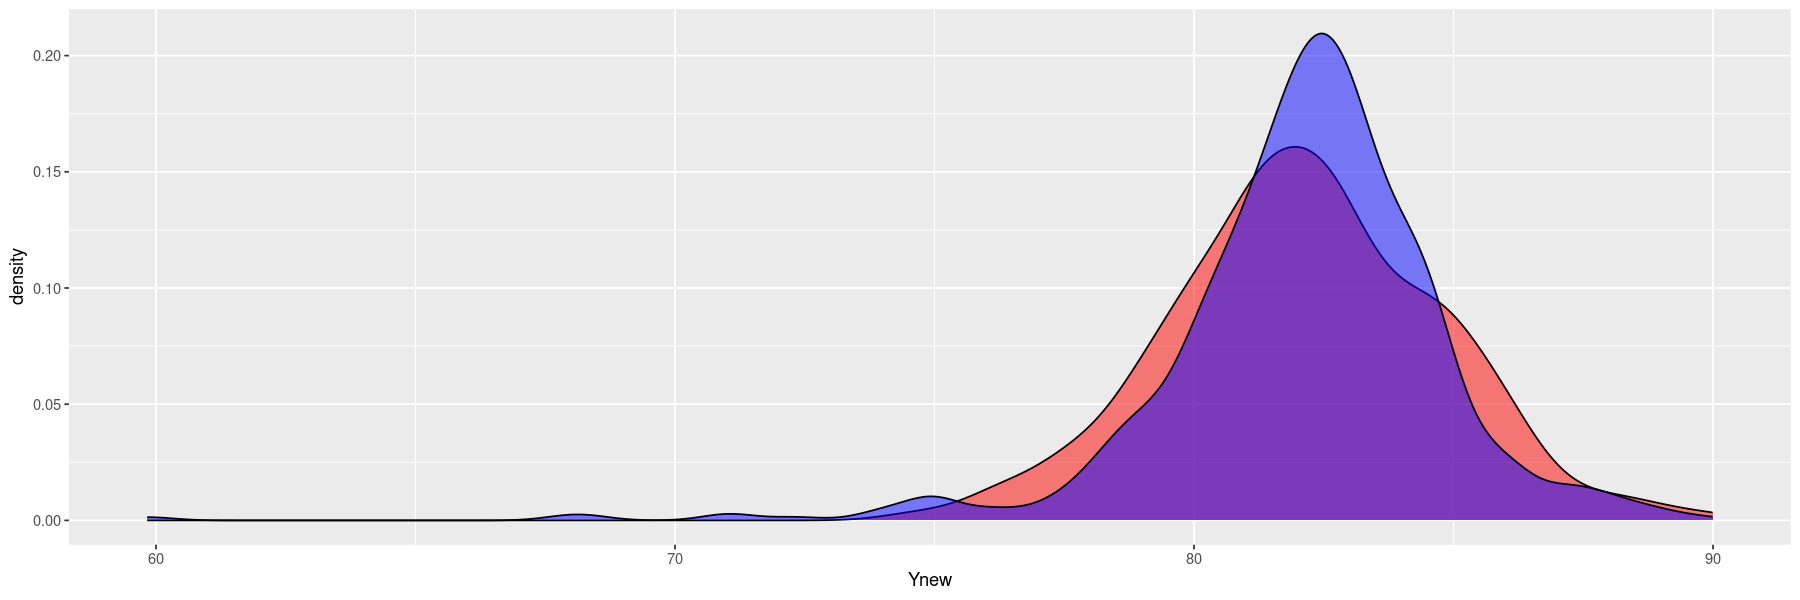

In [17]:
ggplot( sim ) +
    geom_density( aes(x=Ynew), fill="red", alpha=0.5 ) +
    geom_density( aes(x=total_cup_points), fill="blue", alpha=0.5 )

The distributions look more or less. The predicted distribution looks a bit broader and has less outliers than the data distribution (blue).

### c)

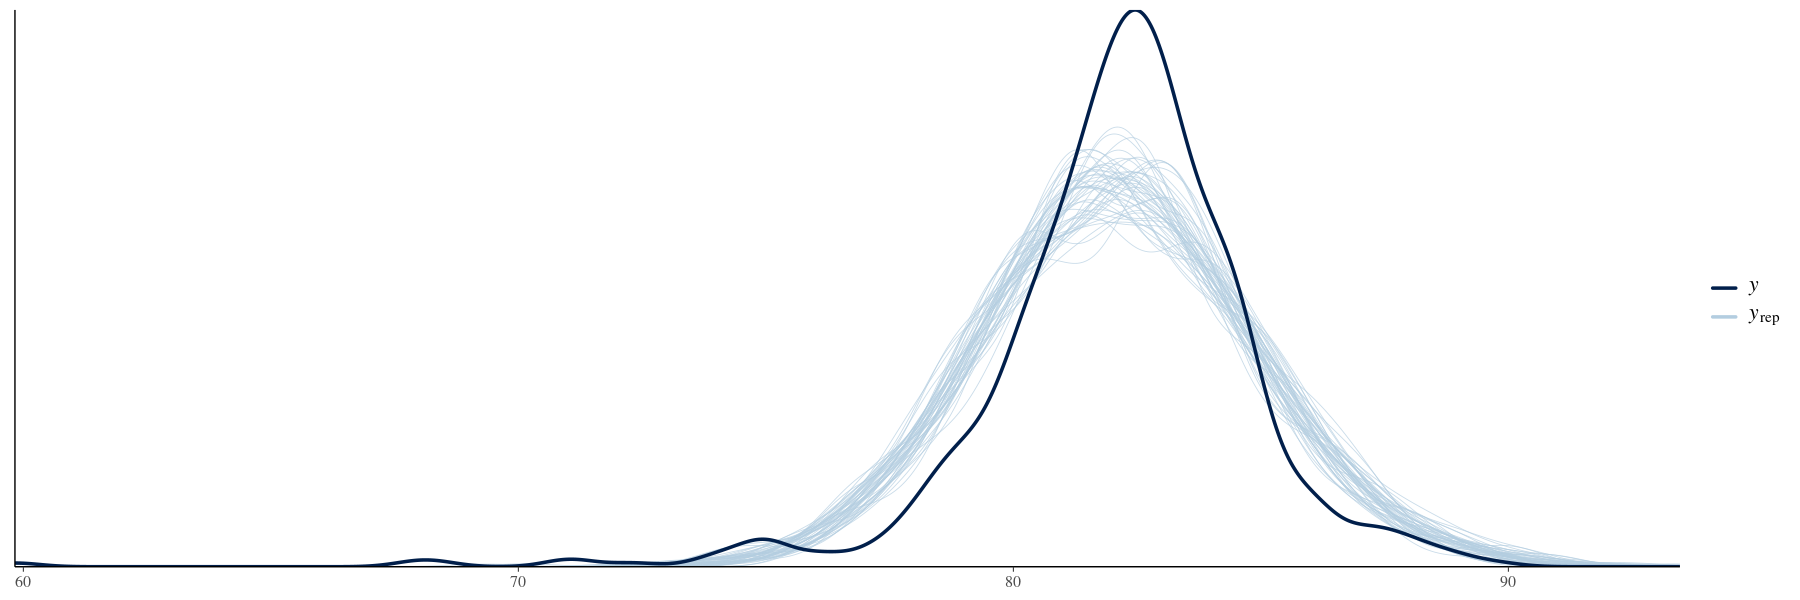

In [18]:
pp_check( coffee_model )

The other simulated parameters seem to show a similar property as in b). The resulting distribution is a bit broader.

### d)

It looks like the original data does not vary exactly normally but is rather a bit more concentrated towards the center. I would assume from a previous plot that the assumption of linearity holds well.

## Exercise 10.16

### a)

In [19]:
pred_sim <- coffee_model_df %>% 
    mutate( mu=X.Intercept.+7.67*aroma ) %>% 
    mutate( Ynew=rnorm(n(), mean=mu, sd=sigma))
head( pred_sim )

,X.Intercept.,aroma,sigma,mu,Ynew
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35.87652,6.096025,1.928280,82.63303,82.47556
2,35.35163,6.180140,1.923063,82.75330,85.23692
3,35.64744,6.135013,1.944249,82.70299,81.22101
4,31.98988,6.617126,1.940026,82.74323,82.39645
5,34.56494,6.276379,1.953897,82.70477,81.86750
6,35.73808,6.118662,1.927848,82.66821,82.73758


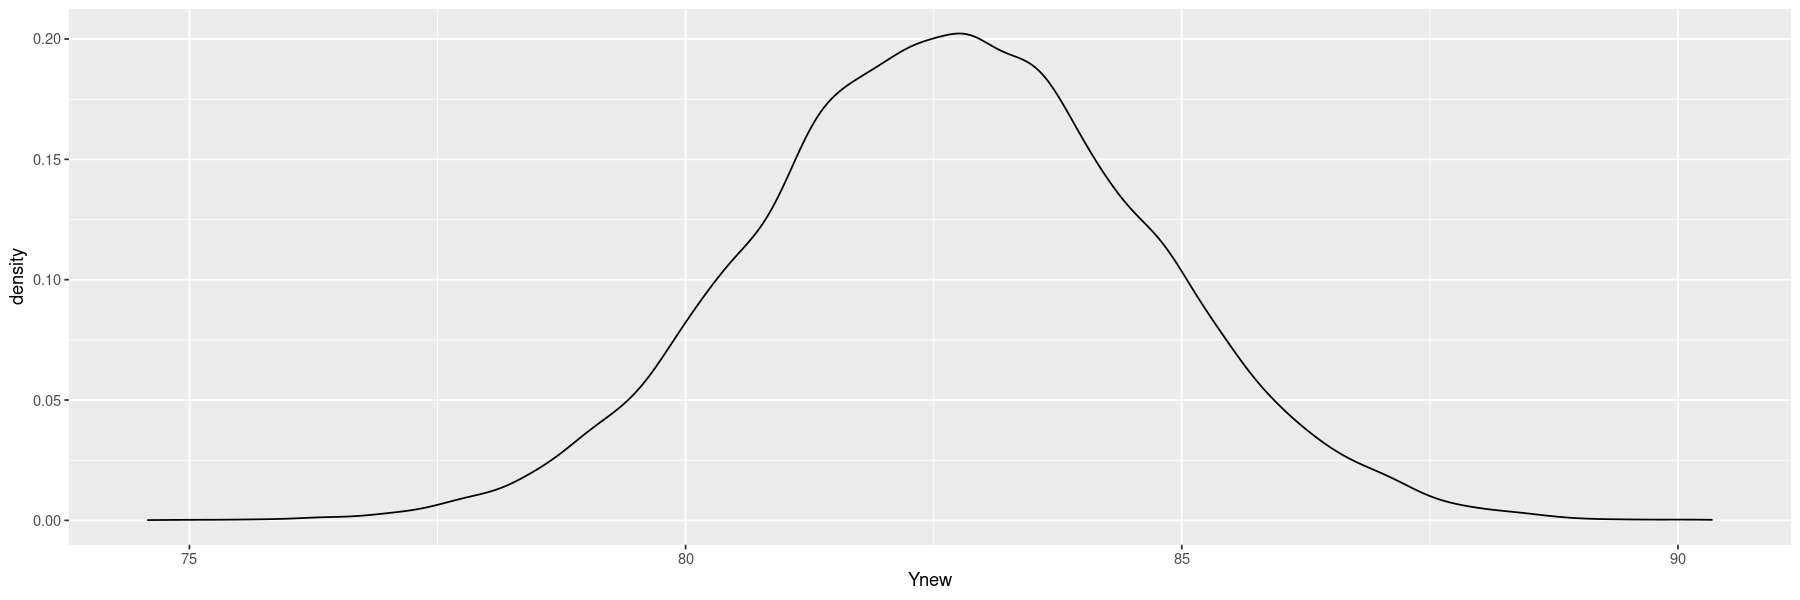

In [20]:
ggplot( pred_sim, aes(x=Ynew) ) + geom_density()

### b)

raw MAE:

In [21]:
median( abs( pred_sim$Ynew - 84 ) )

[1] 1.648481

standardized MAE:

In [22]:
sd( new_coffee$total_cup_points )

[1] 2.747756

In [23]:
median( abs( pred_sim$Ynew - 84 ) ) / sd( new_coffee$total_cup_points )

[1] 0.5999372

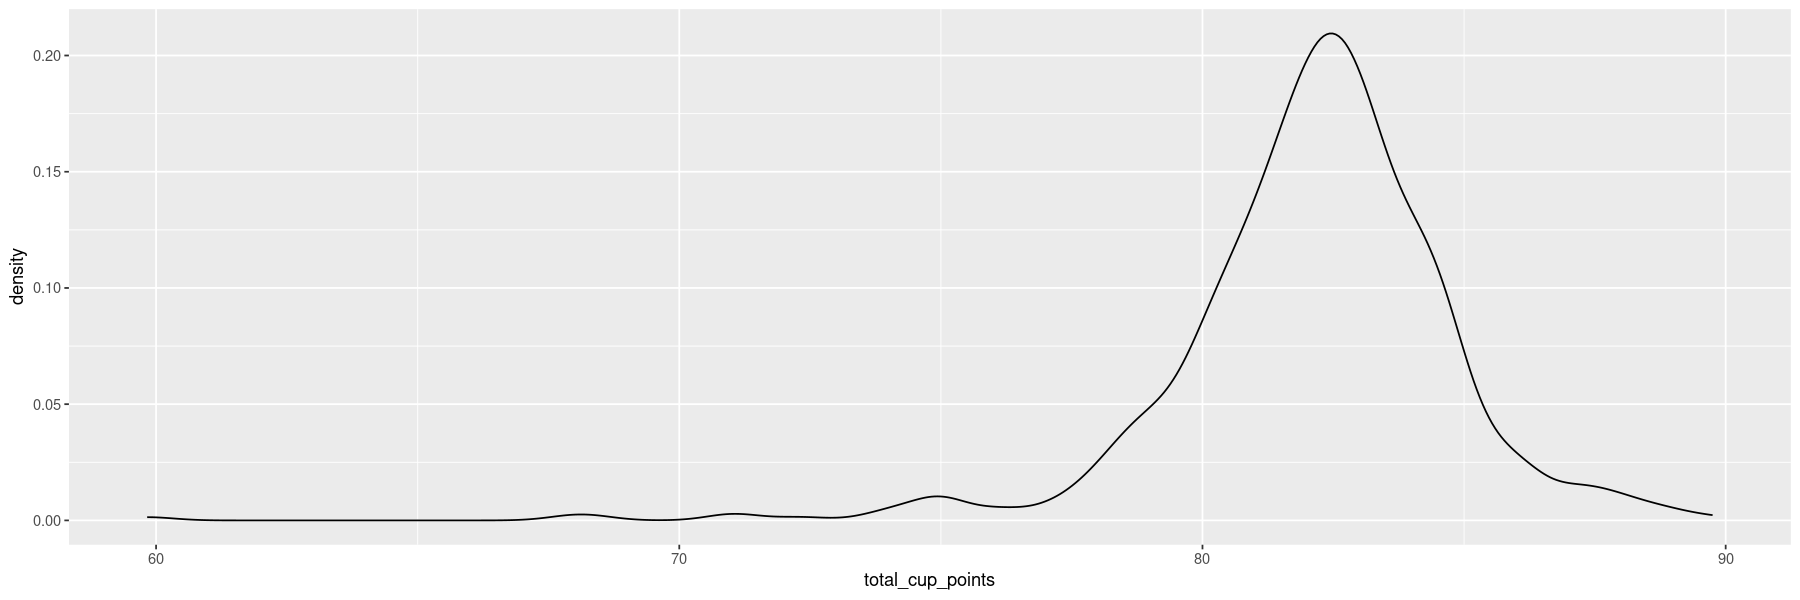

In [24]:
ggplot( new_coffee, aes(x=total_cup_points )) + geom_density()

The predictions deviate by about 60% of the total variation around 84 points (+-1.6 points)

### c)

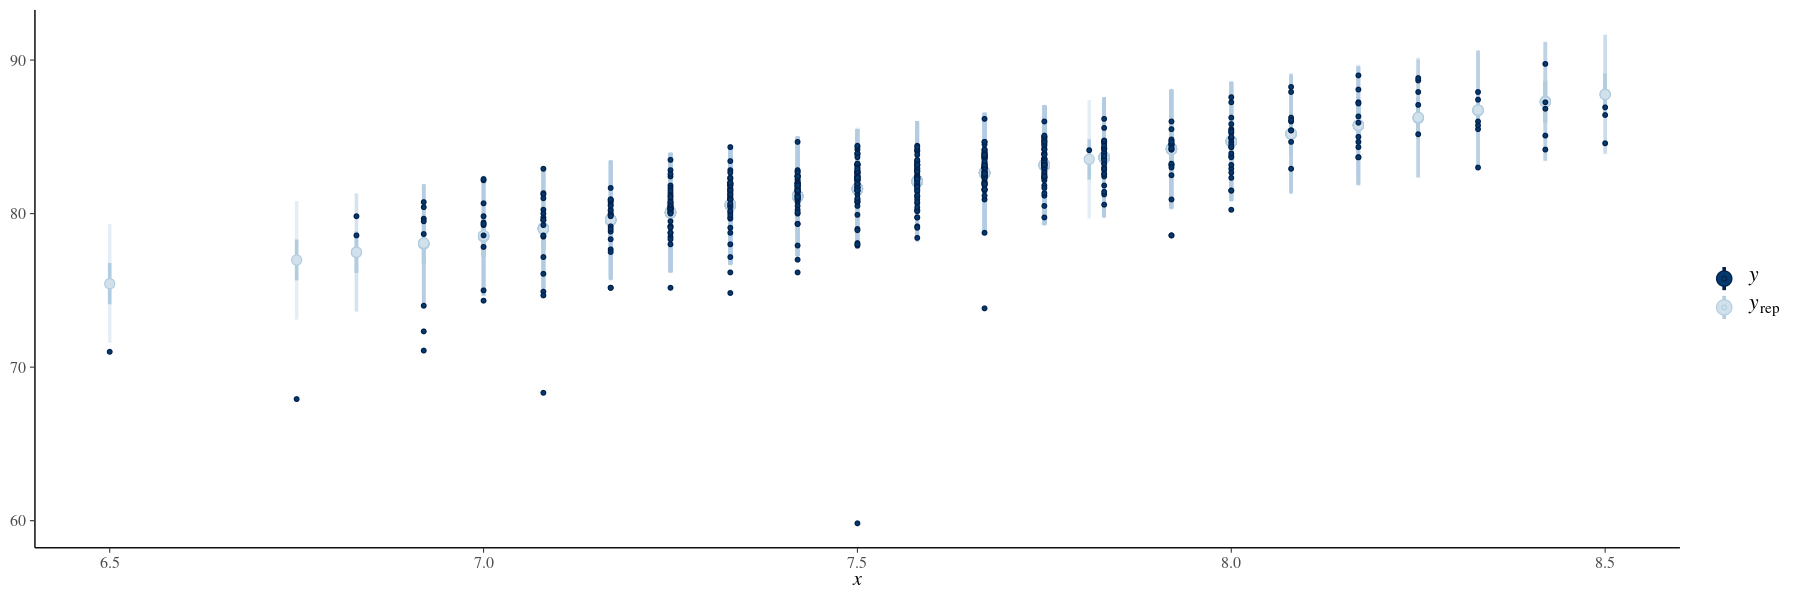

In [25]:
preds <- posterior_predict( coffee_model, newdata=new_coffee )
ppc_intervals(new_coffee$total_cup_points, yrep = preds, x = new_coffee$aroma, prob = 0.5, prob_outer = 0.95)

It looks like the 95% interval covers almost all data points.

### d)

In [26]:
prediction_summary(coffee_model, data = new_coffee)

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
0.8732896,0.4440413,0.6853147,0.9597902


$\sim$69 %

## Exercise 10.17

### a)

In [27]:
cv_procedure <- prediction_summary_cv( model = coffee_model, data = new_coffee, k = 10 )

In [28]:
cv_procedure$cv

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
0.8814543,0.4536989,0.6729583,0.958046


### b)

The results are very similar to the results in the previous exercise without cross-validation. The predictions are an average median away of 0.88 total cup points, amounting to 45% of the total variation in the total cup points. 68% of data points are within the 50% prediction interval and 96% within the 95% prediction interval.

### c)

In [29]:
cv_procedure$folds %>% 
    summarize( mae=mean(mae), mae_scaled=mean(mae_scaled), within_50=mean(within_50), within_95=mean(within_95))

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
0.8814543,0.4536989,0.6729583,0.958046


## Exercise 10.18

Find answers for yourself.

## Exercise 10.19

### a)

In [30]:
coffee_model2 <- stan_glm(
    total_cup_points ~ aftertaste, data = new_coffee,
    family = gaussian,
    prior_intercept = normal(75, 8),
    prior = normal(10, 100, autoscale=TRUE), 
    prior_aux = exponential(1, autoscale=TRUE),
    chains = 4, iter = 5000*2, seed = 84735
)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.229151 seconds (Warm-up)
Chain 1:                0.265065 seconds (Sampling)
Chain 1: 

### b) 

Posterior predictive check:

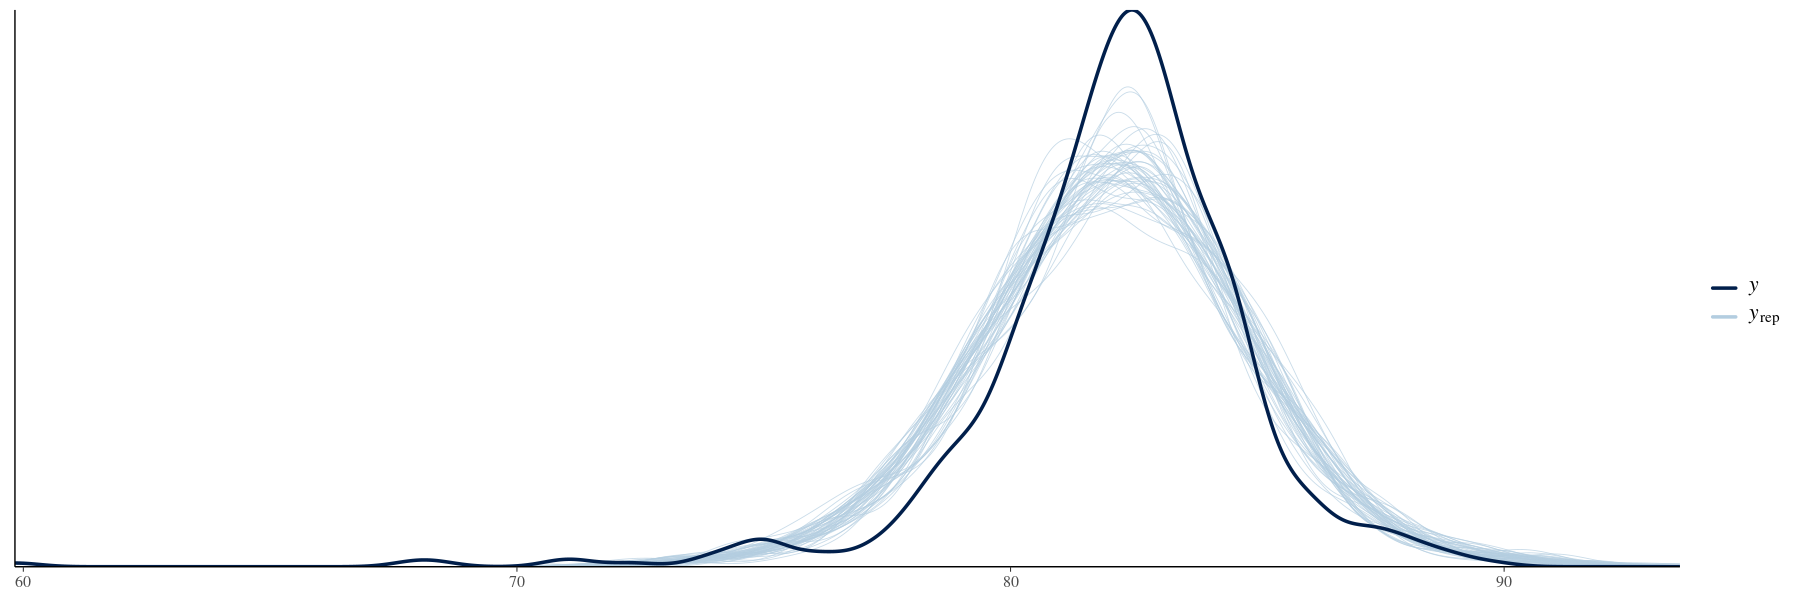

In [31]:
pp_check( coffee_model2 )

Same problems as in the previous model!

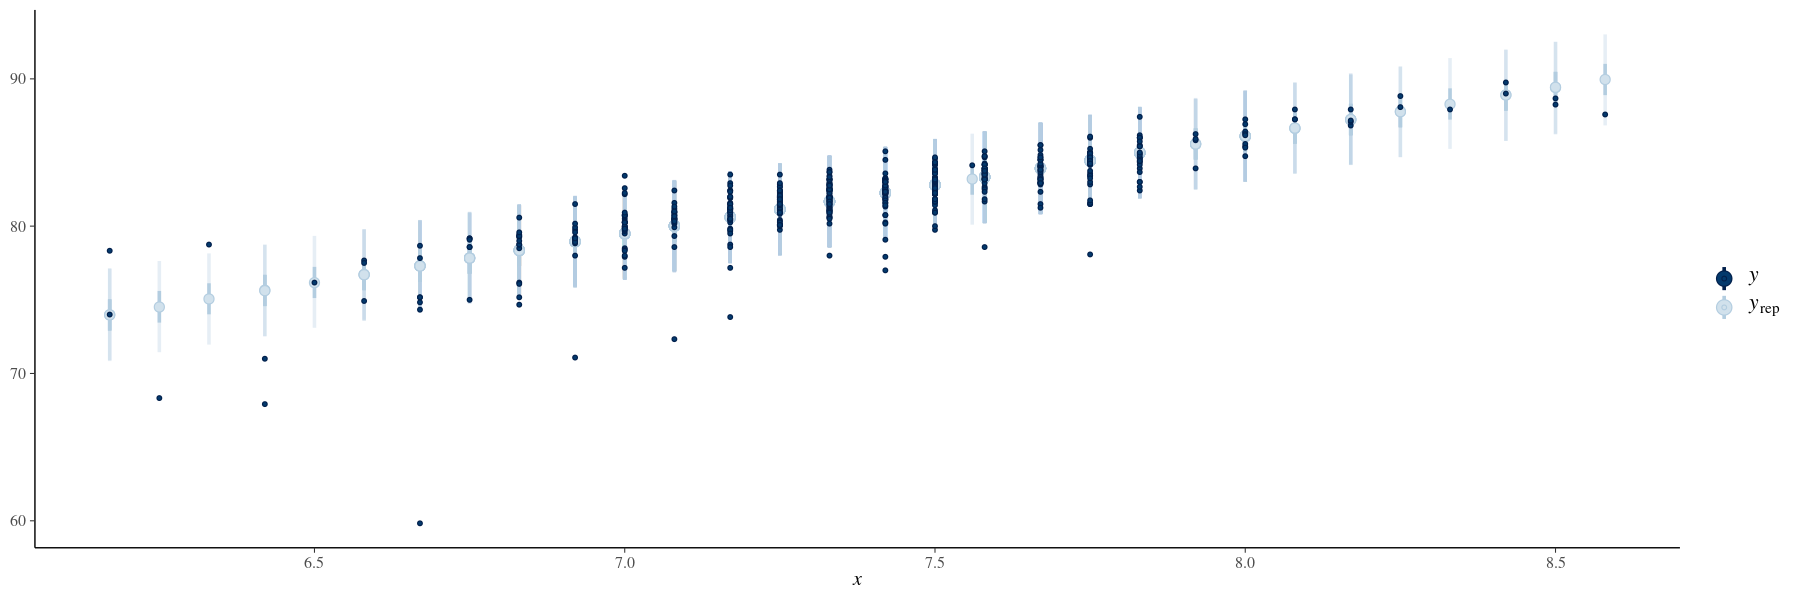

In [32]:
preds <- posterior_predict( coffee_model2, newdata=new_coffee )
ppc_intervals(new_coffee$total_cup_points, yrep = preds, x = new_coffee$aftertaste, prob = 0.5, prob_outer = 0.95)

### c)

In [33]:
cv_procedure <- prediction_summary_cv( model = coffee_model2, data = new_coffee, k = 10 )

In [34]:
cv_procedure$cv

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
0.685346,0.4365701,0.7061101,0.9667877


### d)

Use a model with aftertaste: the model has a slightly better mae and slightly better within_50 and within_95 proportions. 

## Exercise 10.20

### a)

Prior model:

In [35]:
weather_model_prior <- stan_glm(
    maxtemp ~ mintemp, data = weather_perth,
    family = gaussian,
    prior_intercept = normal(25, 1, autoscale=TRUE),
    prior = normal(1, 1, autoscale=TRUE), 
    prior_aux = exponential(1, autoscale=TRUE),
    chains = 4, iter = 5000*2, seed = 84735, prior_PD=TRUE
)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.060797 seconds (Warm-up)
Chain 1:                0.069939 seconds (Sampling)
Chain 1: 

Posterior model:

In [36]:
weather_model_posterior <- stan_glm(
    maxtemp ~ mintemp, data = weather_perth,
    family = gaussian,
    prior_intercept = normal(25, 1, autoscale=TRUE),
    prior = normal(1, 1, autoscale=TRUE), 
    prior_aux = exponential(1, autoscale=TRUE),
    chains = 4, iter = 5000*2, seed = 84735
)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.06884 seconds (Warm-up)
Chain 1:                0.375707 seconds (Sampling)
Chain 1:  

### b)

Prior vs posterior understanding of model parameters:

In [37]:
weather_model_prior_df <- data.frame( weather_model_prior )
weather_model_prior_df$type = "prior"
weather_model_posterior_df <- data.frame( weather_model_posterior )
weather_model_posterior_df$type = "posterior"
weather_model_df <- rbind( weather_model_prior_df, weather_model_posterior_df )
head( weather_model_df )

,X.Intercept.,mintemp,sigma,type
,<dbl>,<dbl>,<dbl>,<chr>
1,28.922924,-0.4391435,0.8766357,prior
2,1.057919,1.9733739,20.4497463,prior
3,7.614472,1.4181872,13.5373976,prior
4,22.448846,0.1572312,2.2348037,prior
5,12.499834,1.3676262,16.8348618,prior
6,16.543891,1.1344354,12.5543647,prior


Summaries:

In [38]:
weather_model_df %>% 
    group_by( type ) %>% 
    summarize_all( c( mean=mean, sd=sd ) )

type,X.Intercept._mean,mintemp_mean,sigma_mean,X.Intercept._sd,mintemp_sd,sigma_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
posterior,14.46882,0.8355819,4.295884,0.3848136,0.02703537,0.09550059
prior,11.42517,1.0229855,5.976854,16.9342544,1.18872170,6.03207056


All the distributions have narrowed by two orders of magnitude!

Density plots:

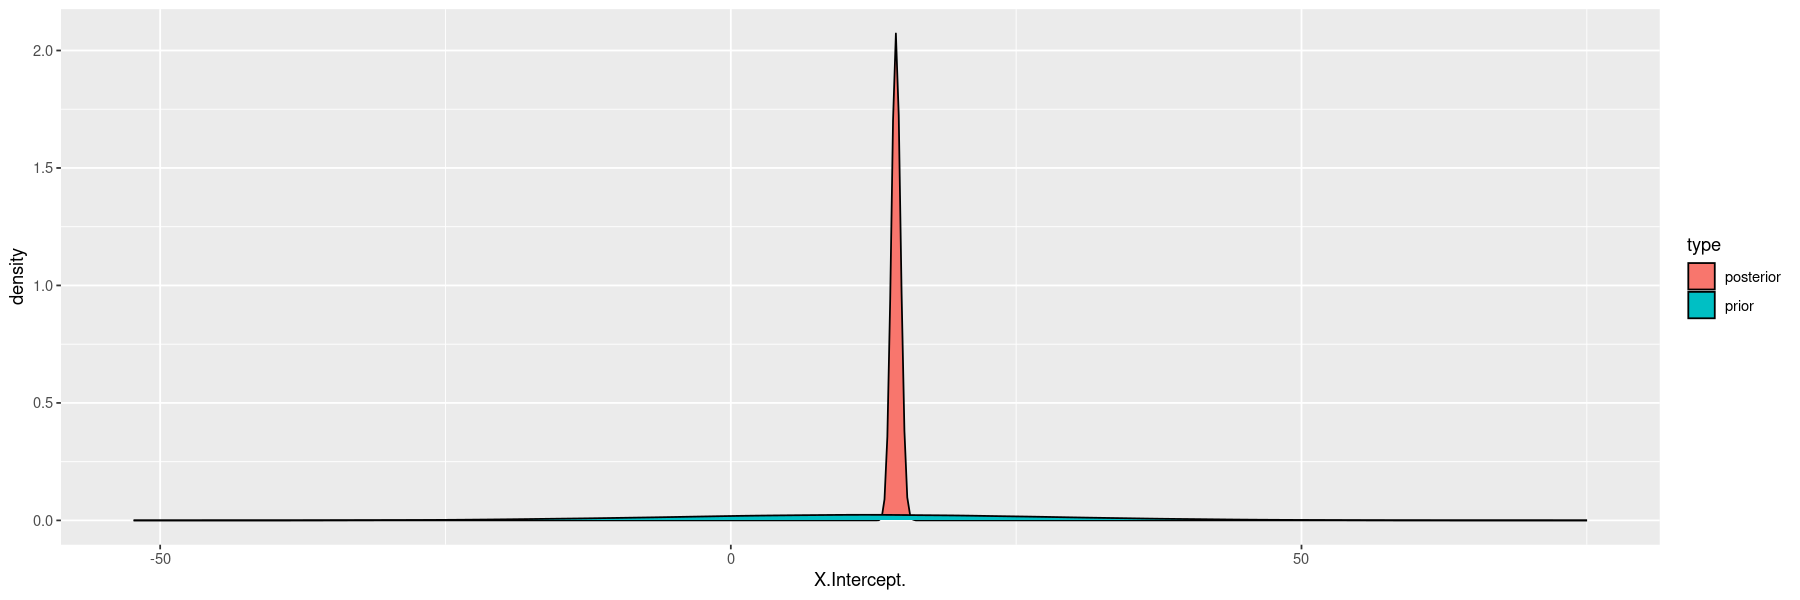

In [39]:
ggplot( data=weather_model_df, aes(x=X.Intercept., fill=type) ) + geom_density()

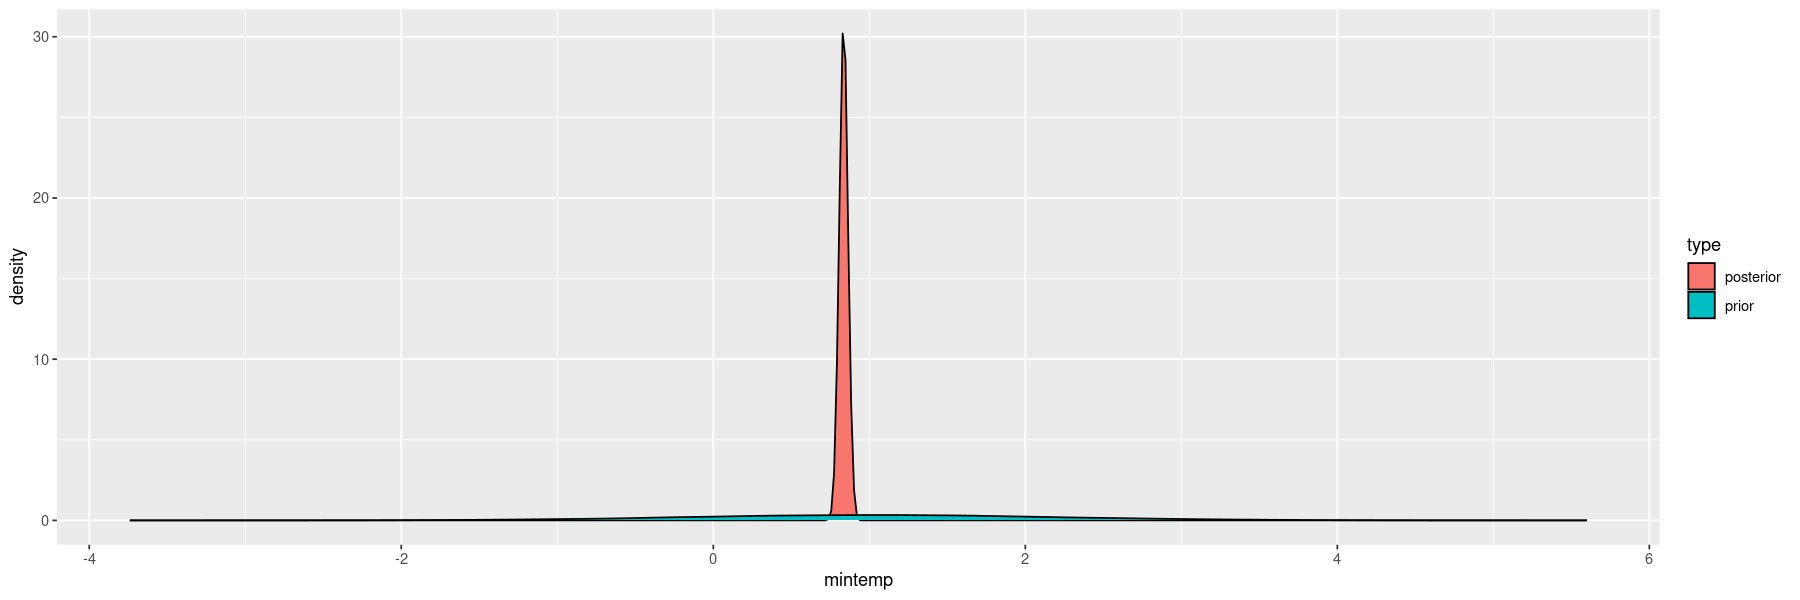

In [40]:
ggplot( data=weather_model_df, aes(x=mintemp, fill=type) ) + geom_density()

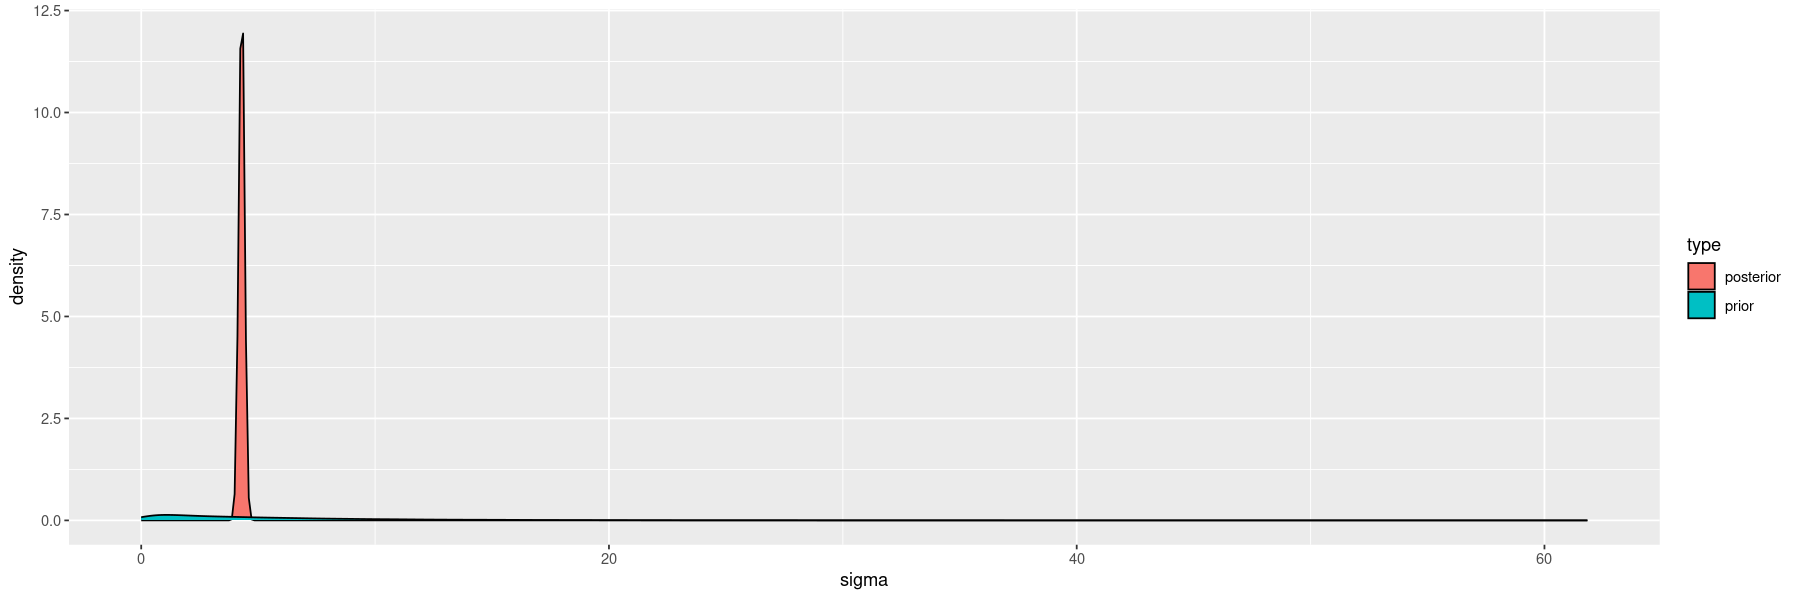

In [41]:
ggplot( data=weather_model_df, aes(x=sigma, fill=type) ) + geom_density()

### c)

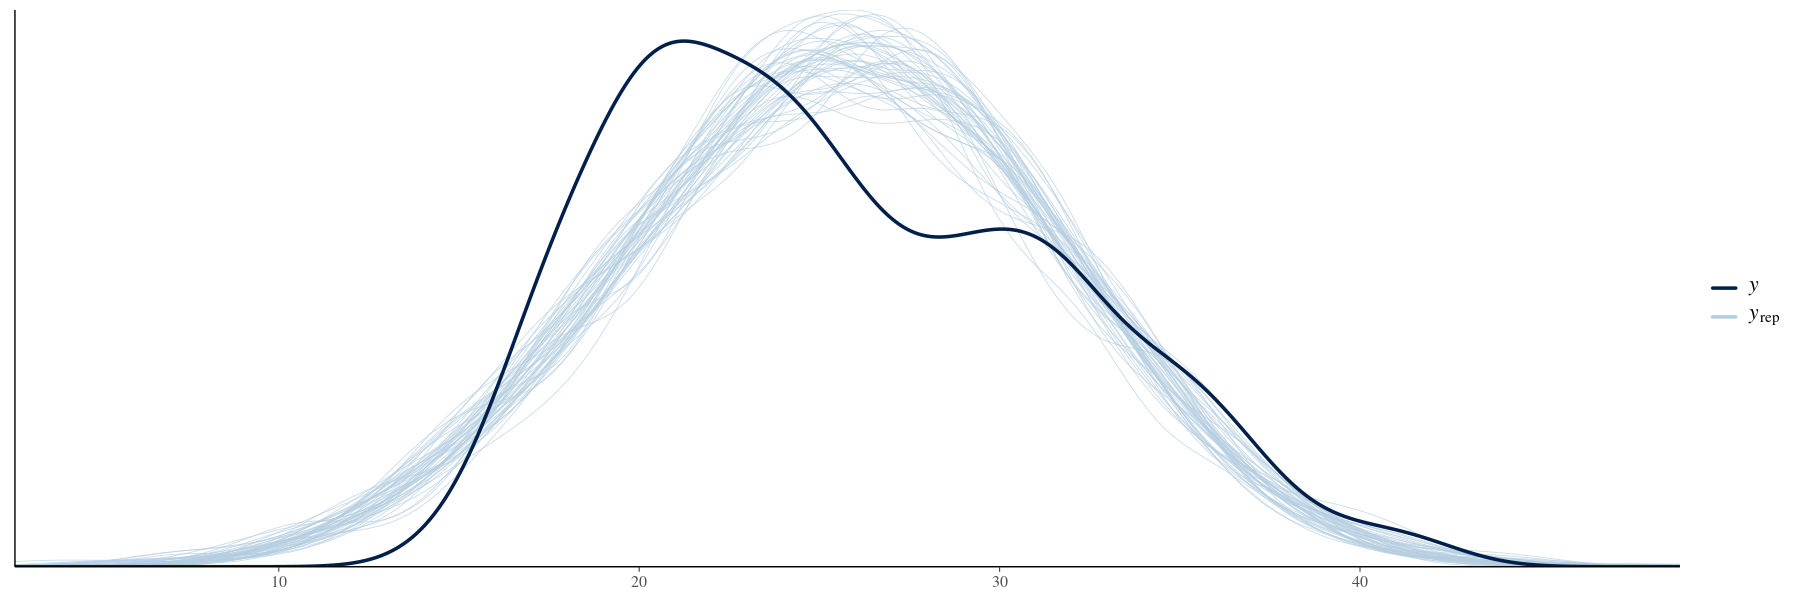

In [42]:
pp_check( weather_model_posterior )

The model does not capture the skewedness of the temperature data.

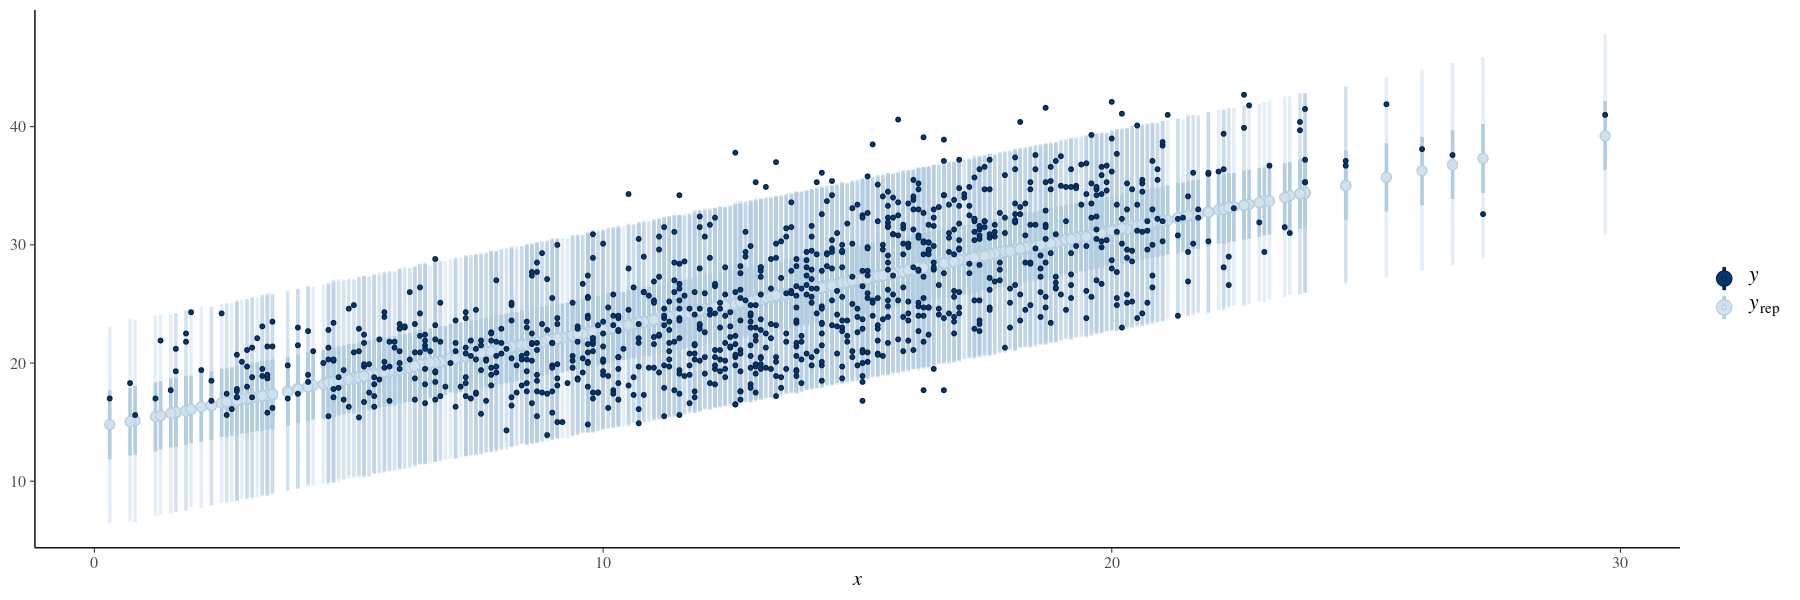

In [43]:
preds <- posterior_predict( weather_model_posterior, newdata=weather_perth )
ppc_intervals(weather_perth$maxtemp, yrep = preds, x = weather_perth$mintemp, prob = 0.5, prob_outer = 0.95)

In [44]:
cv_procedure <- prediction_summary_cv( model = weather_model_posterior, data = weather_perth, k = 10 )
cv_procedure$cv

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
3.208076,0.74615,0.456,0.967


The predictions for the maximum temperature are typically a median distance of $\sim3.2^\circ$ away from the true value. This is 75% of the standard deviation of the distribution of maximum temperatures. 46% of predicted values are within the 50% interval and 97% within the 95% interval. Even though the model assumptions neglect the skewedness of the data distribution, the model reaches nevertheless a reasonable performance.

## Exercise 10.21

### a)

Prior model:

In [45]:
bike_model_prior <- stan_glm(
    rides ~ humidity, data = bikes,
    family = gaussian,
    prior_intercept = normal(5000, 1, autoscale=TRUE),
    prior = normal(10, 1, autoscale=TRUE), 
    prior_aux = exponential(1, autoscale=TRUE),
    chains = 4, iter = 5000*2, seed = 84735, prior_PD=TRUE
)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.159122 seconds (Warm-up)
Chain 1:                0.096874 seconds (Sampling)
Chain 1: 

Posterior model:

In [46]:
bike_model_posterior <- stan_glm(
    rides ~ humidity, data = bikes,
    family = gaussian,
    prior_intercept = normal(5000, 1, autoscale=TRUE),
    prior = normal(10, 1, autoscale=TRUE), 
    prior_aux = exponential(1, autoscale=TRUE),
    chains = 4, iter = 5000*2, seed = 84735
)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.115276 seconds (Warm-up)
Chain 1:                0.230986 seconds (Sampling)
Chain 1: 

### b)

Prior vs posterior understanding of model parameters:

In [47]:
bike_model_prior_df <- data.frame( bike_model_prior )
bike_model_prior_df$type = "prior"
bike_model_posterior_df <- data.frame( bike_model_posterior )
bike_model_posterior_df$type = "posterior"
bike_model_df <- rbind( bike_model_prior_df, bike_model_posterior_df )
head( bike_model_df )

,X.Intercept.,humidity,sigma,type
,<dbl>,<dbl>,<dbl>,<chr>
1,14676.79403,-180.865745,1436.1314,prior
2,-2644.27610,46.306870,641.3266,prior
3,-363.89597,15.013013,900.1117,prior
4,-88.84915,146.237264,1428.3222,prior
5,2097.51609,43.413658,1308.5533,prior
6,5854.25925,-7.884068,880.5950,prior


Summaries:

In [48]:
bike_model_df %>% 
    group_by( type ) %>% 
    summarize_all( c( mean=mean, sd=sd ) )

type,X.Intercept._mean,humidity_mean,sigma_mean,X.Intercept._sd,humidity_sd,sigma_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
posterior,3935.634,-7.093365,1575.314,303.6433,4.65671,50.05677
prior,4380.372,9.644770,1562.423,6695.1907,102.55377,1539.93173


All the distributions have narrowed by 1-2 orders of magnitude!

Density plots:

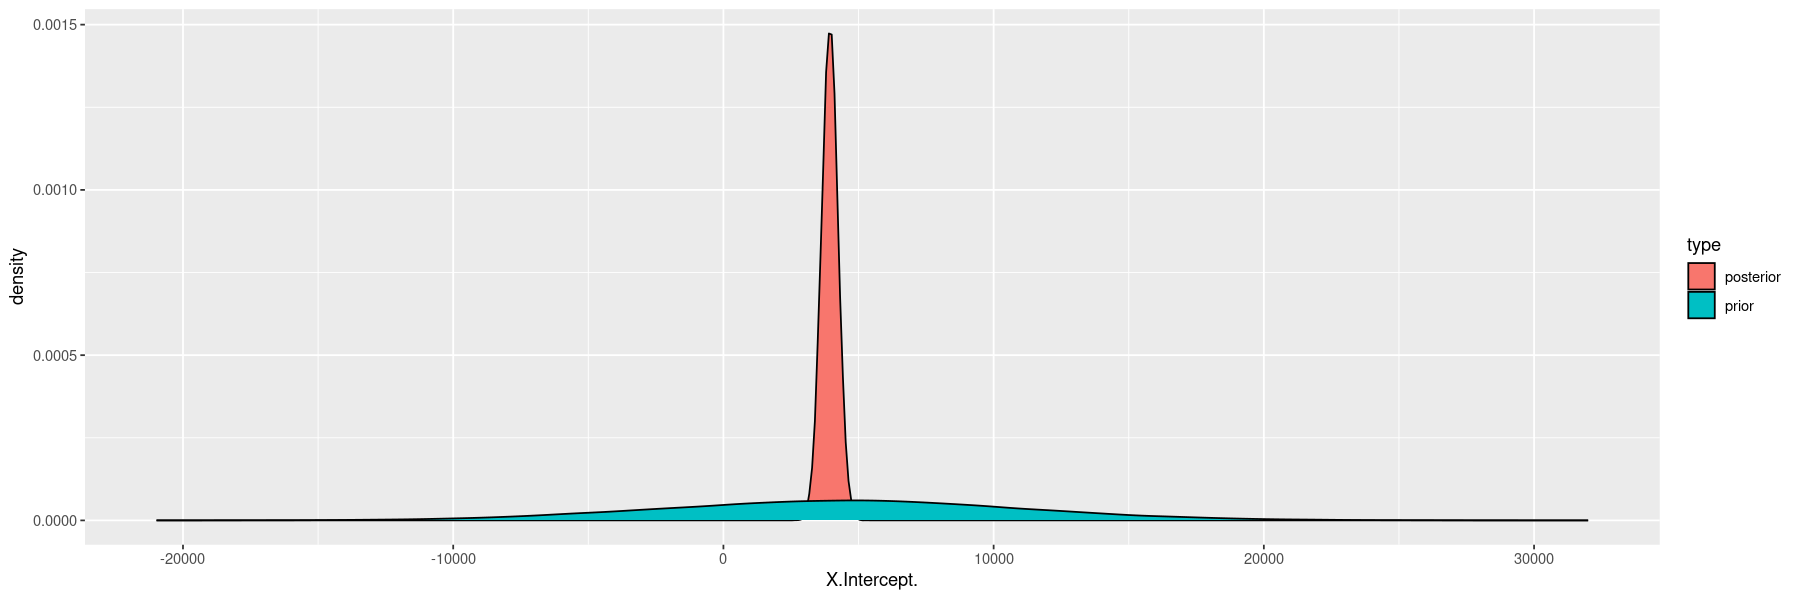

In [49]:
ggplot( data=bike_model_df, aes(x=X.Intercept., fill=type) ) + geom_density()

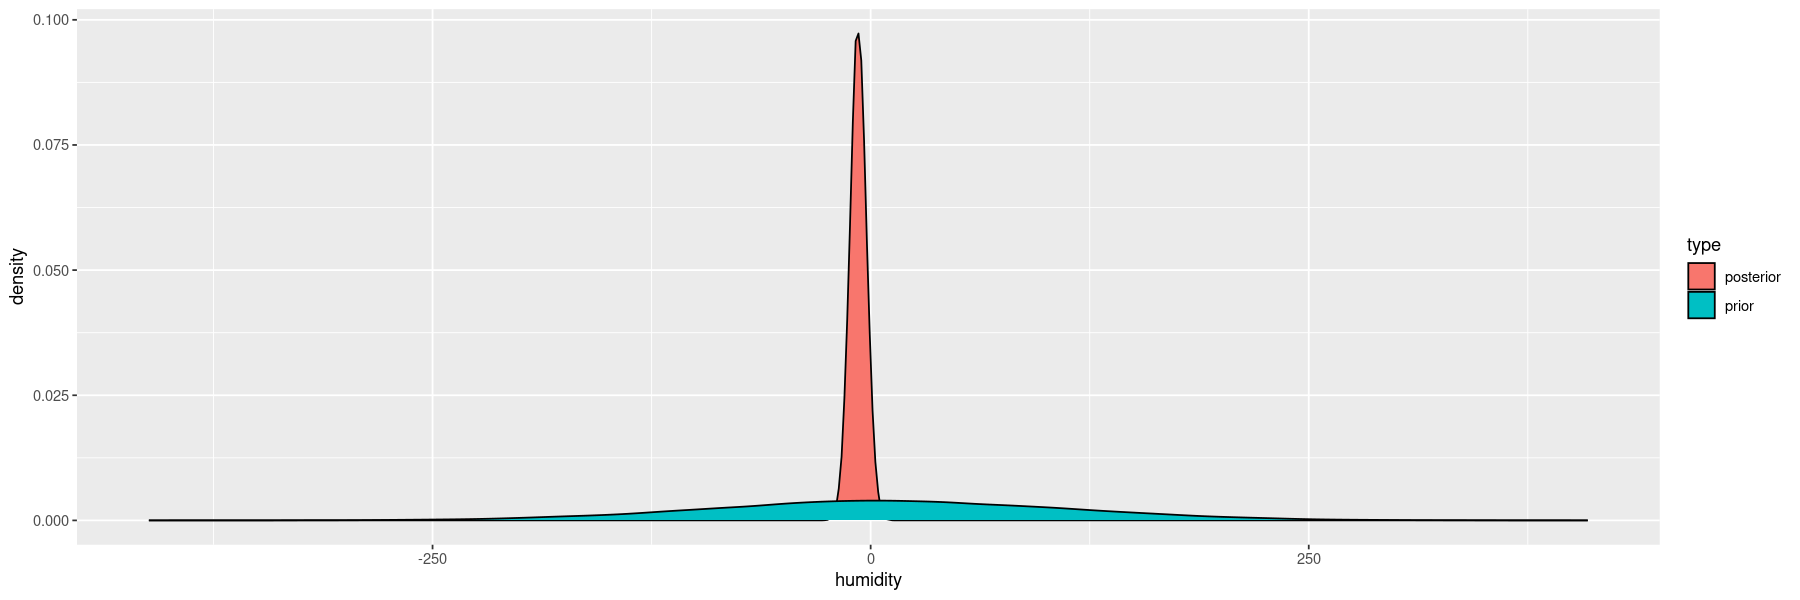

In [50]:
ggplot( data=bike_model_df, aes(x=humidity, fill=type) ) + geom_density()

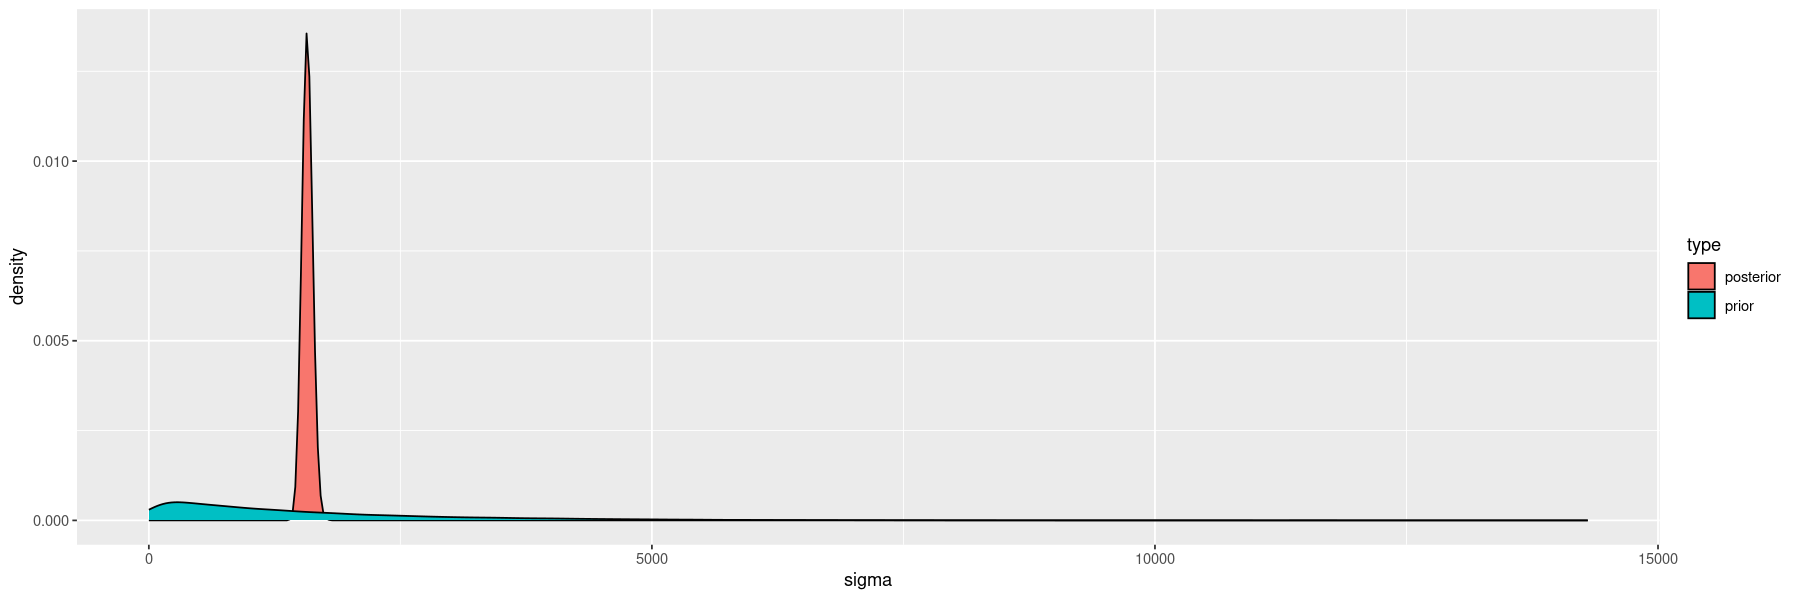

In [51]:
ggplot( data=bike_model_df, aes(x=sigma, fill=type) ) + geom_density()

### c)

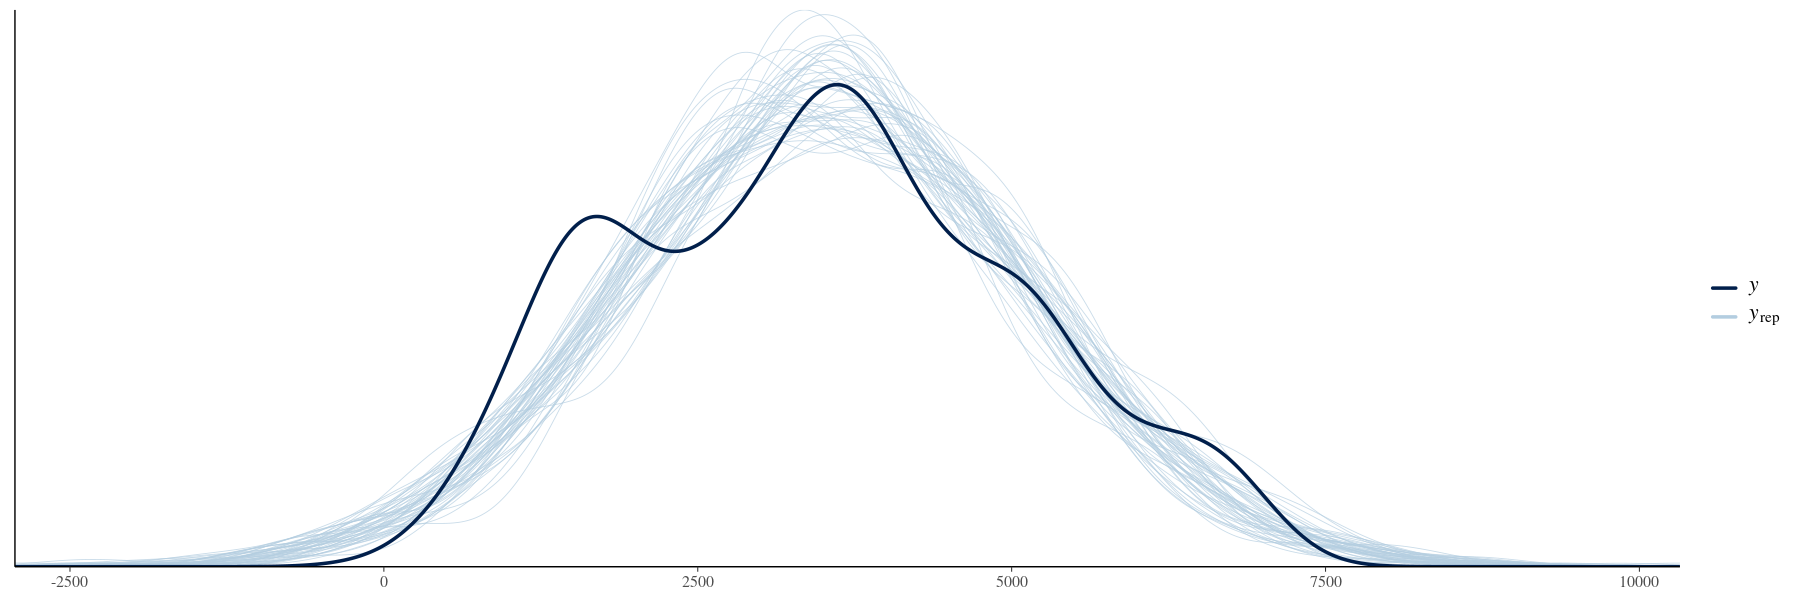

In [52]:
pp_check( bike_model_posterior )

The model does not capture the multimodality of the data distribution.

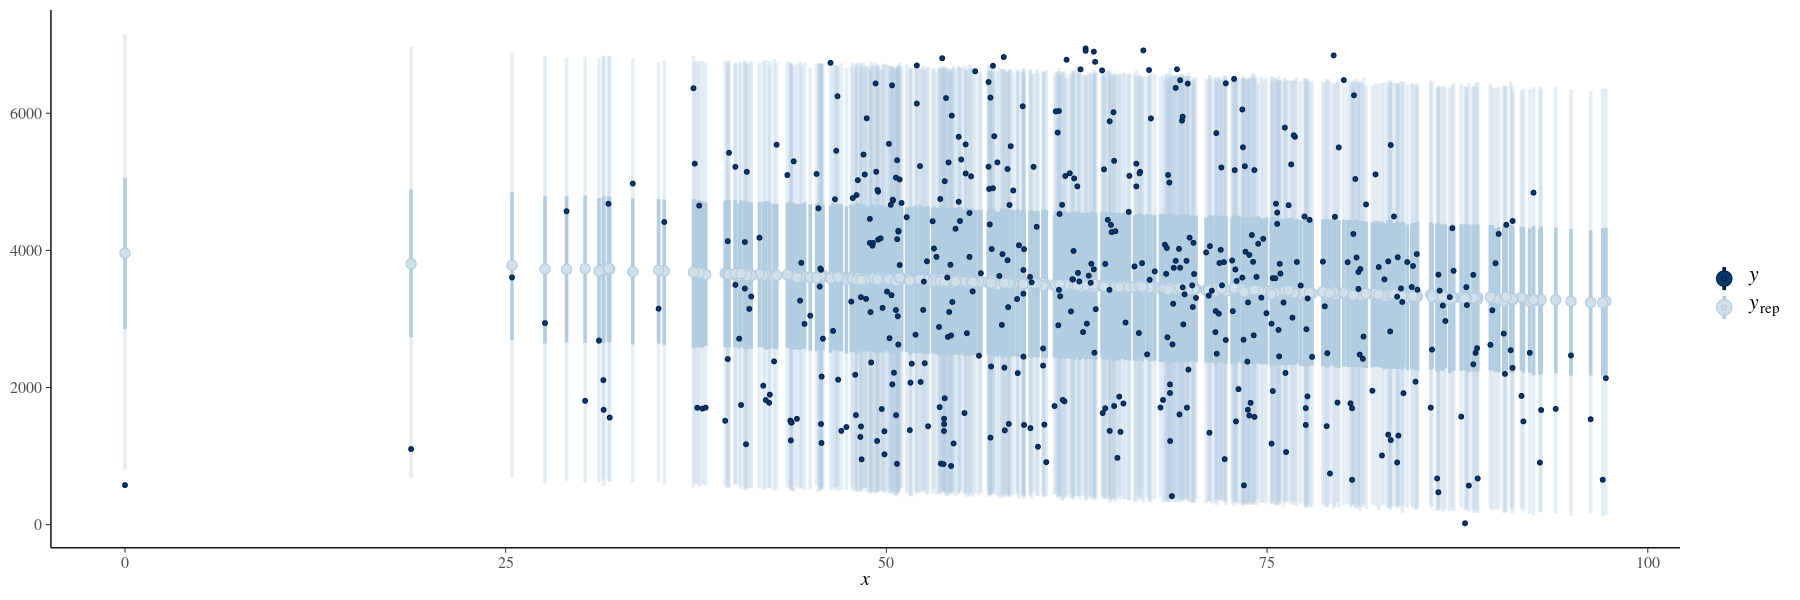

In [53]:
preds <- posterior_predict( bike_model_posterior, newdata=bikes )
ppc_intervals(y = bikes$rides, yrep = preds, x = bikes$humidity, prob = 0.5, prob_outer = 0.95)

In [54]:
cv_procedure <- prediction_summary_cv( model = bike_model_posterior, data = bikes, k = 10 )
cv_procedure$cv

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
1224.292,0.7752638,0.464,0.958


The predicted rides are on median around 1200 riders away from the true data point, amounting to around 78% of the standard deviation of rides data.